# Minimalist RTS Environment (let's call it "Towers")
Sam Greydanus

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# from towers import Towers
from rtsenv import RTSEnv

This implementation generally follows the documentation of Zoe's version. Changes: tower locations, within quadrants, are randomized. Tower values ("healths" aka "hit points"), within quadrants, are randomized. Agent value is randomized. Final reward is computed as follows: `tower_value IF agent_value > tower_value ELSE -3`. Friend towers are treated the same as enemy towers in the reward computation, except their magnitudes are negative.

Channel Overview
 * channel 1 - hit point channel **NON BINARY**
 * channel 2 - agent mask
 * channel 3 - small tower mask
 * channel 4 - large tower mask
 * channel 5 - friendly mask
 * channel 6 - enemy mask
 
NOTE: My implementation follows the OpenAI environment API:
 * `state = env.reset()`
 * `state, reward, done, info = env.step(action)`

In [2]:
class Towers(RTSEnv):
    def __init__(self, quadrant_size=5):
        self.qsize = quadrant_size
        self.labels = ['health', 'agent', 'small', 'large', 'friends', 'enemies']

    def seed(self, seed=0):
        np.random.seed(seed)
        
    def reset(self):
        self.obs = self.get_observation()
        return self.obs.copy()

    def step(self, action, verbose=False):
        qsize = self.qsize ; obs = self.obs
        health, agent, small, large, friends, enemies = obs[0], obs[1], obs[2], obs[3], obs[4], obs[5]
        agent_health = (health*agent).sum()
        xi = 0 if action in [0,3] else qsize
        yi = 0 if action in [0,1] else qsize
        tower_health = ((1-agent[xi:xi+qsize,yi:yi+qsize])*health[xi:xi+qsize,yi:yi+qsize]).sum()
        if verbose: print('tower health', tower_health, '\tagent health', agent_health)
        reward = tower_health if tower_health < agent_health else -3.
        state = None ; done = True ; info = {}
        return state, reward, done, info
    
    def get_observation(self):
        channels = [self.get_health_mask(self.qsize)]
        channels += [self.get_agent_mask(self.qsize)]
        channels += self.get_tower_masks(self.qsize, channels[0])
        channels += self.get_team_masks(self.qsize, channels[0])
        channels[0] += np.abs(channels[1]*np.random.randn())     # add the agent to the health channel
        channels[0] += (0.5-1)*(channels[2]*channels[0]) # small towers get a health in range (0,0.5)
        channels[0] += (1.5-1)*(channels[3]*channels[0]) # large towers get a health in range (0,1.5)
        return np.stack(channels)
    
    @staticmethod
    def get_health_mask(qsize):
        channel = np.zeros((qsize*2, qsize*2))
        for i in range(2):
            for j in range(2):
                ix = (np.random.randint(qsize*i, qsize*(i+1)), np.random.randint(qsize*j, qsize*(j+1)))
                channel[ix] = np.random.randn()
        return channel
    
    @staticmethod
    def get_agent_mask(qsize): # agent will always be in the middle. model should learn to ignore
        channel = np.zeros((qsize*2, qsize*2)) ; channel[qsize,qsize] = 1
        return channel
    
    @staticmethod
    def get_tower_masks(qsize, health_channel):
        tower_exists = health_channel != 0
        small = np.random.rand(qsize*2, qsize*2) > 0.5
        large = 1-small # this is a redundant layer...but whatever
        return [small*tower_exists, large*tower_exists]
    
    @staticmethod
    def get_team_masks(qsize, health_channel):
        tower_exists = health_channel != 0
        friends = health_channel < 0
        enemies = health_channel > 0 # this is a redundant layer...but whatever
        return [friends, enemies] #[team1*tower_exists, team2*tower_exists]

## Visualize the channels

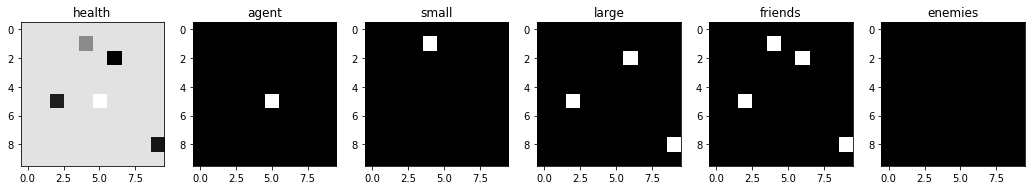

In [3]:
env = Towers()
obs = env.reset()

side=3
f = plt.figure(figsize=[6*side,side])
for i in range(6):
    plt.subplot(1,6,1+i)
    plt.title(env.labels[i])
    plt.imshow(obs[i], cmap='gray')
plt.show()

## Explore the reward

In [4]:
for a in range(4):
    _, r,_,_ = env.step(a, verbose=True)
    print('reward', r, end='\n\n')

tower health -0.5158757430926123 	agent health 0.1781860983311189
reward -0.5158757430926123

tower health -1.1613807591566412 	agent health 0.1781860983311189
reward -1.1613807591566412

tower health -1.2196567171611339 	agent health 0.1781860983311189
reward -1.2196567171611339

tower health -1.3453844702765596 	agent health 0.1781860983311189
reward -1.3453844702765596



## Time it!

Comparing it to a Torch operation of roughly the same complexity as a forward pass of a NN. It appears simulation time is not an issue here.

In [5]:
import torch, time

# time it: approximate complexity of a NN forward pass
start = time.time()
matrices = [torch.randn(128,28,28) for i in range(10)]
v = None
for i, m in enumerate(matrices):
    v = m if i==0 else v.mul(m)
print("mock forward pass took ~{:.3f}s".format(time.time()-start))

# time it: get an observation then get a reward
start = time.time()
obs = env.reset()
_, r,_,_ = env.step(1)
print("environment part took ~{:.3f}s".format(time.time()-start))

mock forward pass took ~0.061s
environment part took ~0.001s
